# Notebook 3 : CNN sur bins temporels

## Approche

Plutôt que de traiter les spikes individuellement, on **discrétise le temps** en petits bins et on construit une "image" 2D (canaux × bins temporels) pour chaque fenêtre. On y stocke l'amplitude maximale des spikes détectés dans chaque bin. Cette image est ensuite traitée par un **CNN 2D**.

**Pourquoi cette approche ?**
- **Dimension d'entrée fixe** : pas besoin de padding variable ni de masque d'attention
- **Les CNN 2D** sont très efficaces pour capturer des patterns spatio-temporels locaux
- Les filtres 2D peuvent apprendre des motifs comme "activité simultanée sur les canaux 3 et 7" ou "séquence rapide d'activation"

**Inconvénient** : on perd les waveforms individuels (on ne garde qu'une statistique agrégée par bin).

**Framework** : PyTorch, accéléré sur MPS (Apple Silicon).

## 1. Imports et configuration

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

In [ ]:
# --- Connexion S3 (Onyxia) ou chargement local ---
S3_ENDPOINT = "https://minio.lab.sspcloud.fr"
S3_BUCKET = "gmarguier"
S3_PREFIX = "hacktion-potential"

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

LOCAL_DIR = os.path.abspath('..')
LOCAL_PARQUET = os.path.join(LOCAL_DIR, PARQUET_NAME)
LOCAL_JSON = os.path.join(LOCAL_DIR, JSON_NAME)

USE_S3 = False
fs = None

try:
    import s3fs
    fs = s3fs.S3FileSystem(
        client_kwargs={"endpoint_url": S3_ENDPOINT},
        anon=True
    )
    s3_parquet = f"{S3_BUCKET}/{S3_PREFIX}/{PARQUET_NAME}"
    if fs.exists(s3_parquet):
        USE_S3 = True
        print(f"[S3] Connexion OK — lecture depuis s3://{S3_BUCKET}/{S3_PREFIX}/")
    else:
        print(f"[S3] Bucket accessible mais fichier introuvable ({s3_parquet})")
except Exception as e:
    print(f"[S3] Non disponible ({type(e).__name__}: {e})")

if not USE_S3:
    if os.path.exists(LOCAL_PARQUET):
        print(f"[LOCAL] Chargement depuis {LOCAL_DIR}/")
    else:
        raise FileNotFoundError(f"Données introuvables ni sur S3 ni en local ({LOCAL_PARQUET})")

## 2. Chargement et filtrage

In [ ]:
print('Chargement...')
if USE_S3:
    with fs.open(f"{S3_BUCKET}/{S3_PREFIX}/{PARQUET_NAME}", "rb") as f:
        df = pd.read_parquet(f)
    with fs.open(f"{S3_BUCKET}/{S3_PREFIX}/{JSON_NAME}", "r") as f:
        params = json.load(f)
else:
    df = pd.read_parquet(LOCAL_PARQUET)
    with open(LOCAL_JSON, 'r') as f:
        params = json.load(f)

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
total_channels = sum(nChannelsPerGroup)  # 20
print(f'nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}, total={total_channels}')

speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

## 3. Preprocessing : construction de la matrice spike-bin

Pour chaque fenêtre de 108ms, on :
1. Découpe le temps en bins de 5ms → ~21 bins
2. Pour chaque spike, on détermine dans quel bin il tombe (via `indexInDat`)
3. On remplit la matrice `(total_channels, n_bins)` avec l'amplitude max du spike pour chaque canal

On utilise 2 canaux d'information :
- **Canal 1** : comptage de spikes (combien de spikes dans ce bin pour ce canal)
- **Canal 2** : amplitude maximale (peak-to-trough) du spike le plus fort dans ce bin

L'image finale a donc la shape `(2, total_channels, n_bins)` — comme une image RGB mais avec 2 canaux.

In [20]:
BIN_SIZE_MS = 5.0  # Taille de chaque bin en ms
WINDOW_MS = 108.0
N_BINS = int(np.ceil(WINDOW_MS / BIN_SIZE_MS))  # 22 bins
SAMPLING_RATE = 20000  # Hz
BIN_SIZE_SAMPLES = int(BIN_SIZE_MS * SAMPLING_RATE / 1000)  # 100 samples par bin

print(f'Bins: {N_BINS} bins de {BIN_SIZE_MS}ms ({BIN_SIZE_SAMPLES} samples/bin)')
print(f'Image shape: (2, {total_channels}, {N_BINS})')

# Mapping canal global : shank 0 canaux 0-5, shank 1 canaux 6-9, etc.
channel_offset = [0]
for g in range(nGroups - 1):
    channel_offset.append(channel_offset[-1] + nChannelsPerGroup[g])
print(f'Channel offsets: {channel_offset}')

Bins: 22 bins de 5.0ms (100 samples/bin)
Image shape: (2, 20, 22)
Channel offsets: [0, 6, 10, 16]


In [21]:
def build_spike_image(row, nGroups, nChannelsPerGroup, channel_offset,
                       total_channels, n_bins, bin_size_samples):
    """
    Construit l'image (2, total_channels, n_bins) pour un exemple.
    Canal 0 = spike count, Canal 1 = amplitude max.
    """
    image = np.zeros((2, total_channels, n_bins), dtype=np.float32)
    
    groups = row['groups']
    index_in_dat = row['indexInDat']
    length = len(groups)
    
    if length == 0:
        return image
    
    # Temps de référence : premier spike
    t0 = index_in_dat[0]
    
    # Reshape des waveforms par shank
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        
        if idx <= 0 or idx > waveforms[g].shape[0]:
            continue
        
        spike = waveforms[g][idx - 1]  # (nCh, 32), 1-based index
        
        # Déterminer le bin temporel
        time_offset = index_in_dat[t] - t0
        bin_idx = int(time_offset / bin_size_samples)
        bin_idx = min(bin_idx, n_bins - 1)
        bin_idx = max(bin_idx, 0)
        
        # Remplir l'image pour chaque canal du shank
        nCh = nChannelsPerGroup[g]
        for ch in range(nCh):
            global_ch = channel_offset[g] + ch
            amp = np.max(spike[ch]) - np.min(spike[ch])  # peak-to-trough
            image[0, global_ch, bin_idx] += 1  # spike count
            image[1, global_ch, bin_idx] = max(image[1, global_ch, bin_idx], amp)  # max amplitude
    
    return image


# Test
test_img = build_spike_image(df_moving.iloc[0], nGroups, nChannelsPerGroup, 
                              channel_offset, total_channels, N_BINS, BIN_SIZE_SAMPLES)
print(f'Image test shape: {test_img.shape}')
print(f'Spike counts non-zéro: {np.count_nonzero(test_img[0])}')
print(f'Amplitude max: {test_img[1].max():.1f}')

Image test shape: (2, 20, 22)
Spike counts non-zéro: 262
Amplitude max: 317.4


In [22]:
# Pré-calculer toutes les images (~ 1-3 min)
print('Construction des images spike-bin...')
all_images = np.zeros((len(df_moving), 2, total_channels, N_BINS), dtype=np.float32)
all_targets = np.zeros((len(df_moving), 2), dtype=np.float32)

for idx in range(len(df_moving)):
    if idx % 5000 == 0:
        print(f'  {idx}/{len(df_moving)}')
    row = df_moving.iloc[idx]
    all_images[idx] = build_spike_image(row, nGroups, nChannelsPerGroup,
                                         channel_offset, total_channels, N_BINS, BIN_SIZE_SAMPLES)
    pos = row['pos']
    all_targets[idx] = [pos[0], pos[1]]

print(f'Images: {all_images.shape}, Targets: {all_targets.shape}')

Construction des images spike-bin...
  0/22974
  5000/22974
  10000/22974
  15000/22974
  20000/22974
Images: (22974, 2, 20, 22), Targets: (22974, 2)


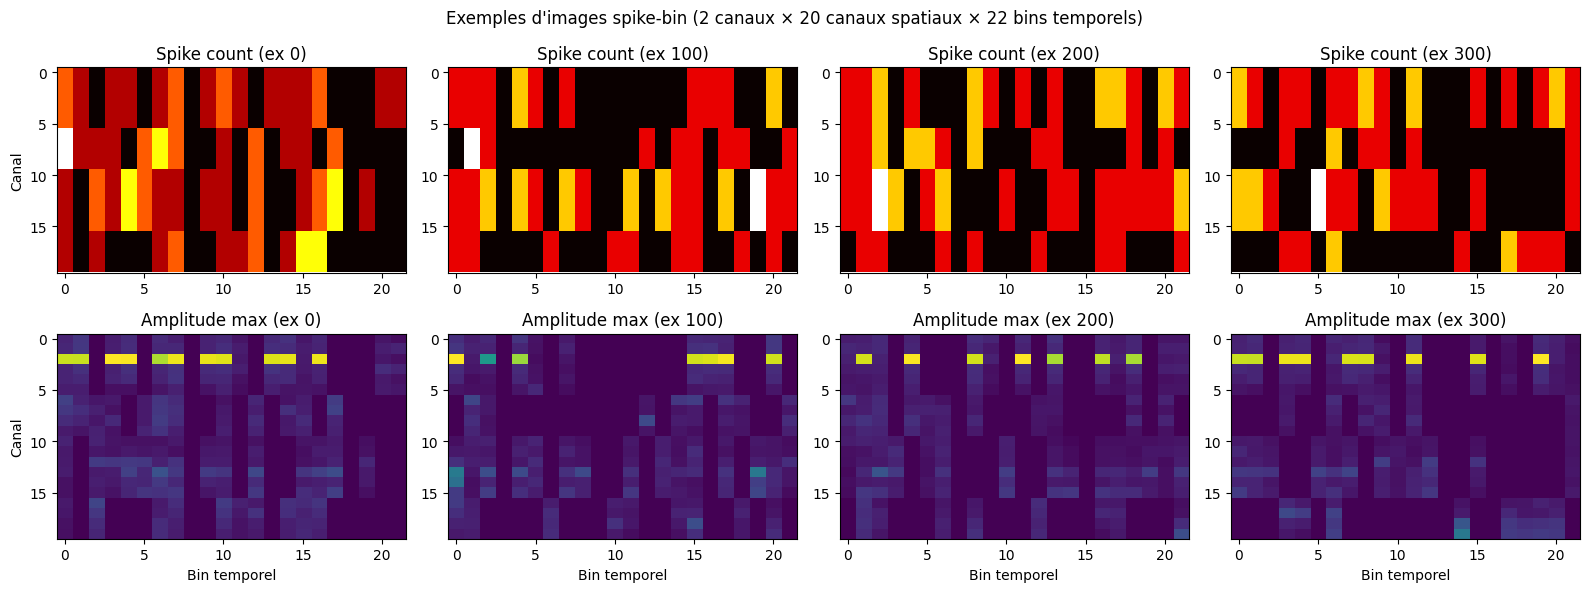

In [23]:
# Visualiser quelques exemples d'images
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i in range(4):
    axes[0, i].imshow(all_images[i * 100, 0], aspect='auto', cmap='hot', interpolation='nearest')
    axes[0, i].set_title(f'Spike count (ex {i*100})')
    axes[0, i].set_ylabel('Canal') if i == 0 else None
    
    axes[1, i].imshow(all_images[i * 100, 1], aspect='auto', cmap='viridis', interpolation='nearest')
    axes[1, i].set_title(f'Amplitude max (ex {i*100})')
    axes[1, i].set_xlabel('Bin temporel')
    axes[1, i].set_ylabel('Canal') if i == 0 else None

plt.suptitle('Exemples d\'images spike-bin (2 canaux × 20 canaux spatiaux × 22 bins temporels)')
plt.tight_layout()
plt.show()

## 4. Normalisation et split

In [24]:
# Split temporel 80/20
split_idx = int(len(all_images) * 0.8)

X_train = all_images[:split_idx]
X_test = all_images[split_idx:]
y_train = all_targets[:split_idx]
y_test = all_targets[split_idx:]

# Normalisation par canal : on calcule mean/std sur le train set
# Pour le canal 0 (count) et canal 1 (amplitude) séparément
for c in range(2):
    mean_c = X_train[:, c].mean()
    std_c = X_train[:, c].std() + 1e-8
    X_train[:, c] = (X_train[:, c] - mean_c) / std_c
    X_test[:, c] = (X_test[:, c] - mean_c) / std_c

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Train targets: {y_train.shape}, Test targets: {y_test.shape}')

Train: (18379, 2, 20, 22), Test: (4595, 2, 20, 22)
Train targets: (18379, 2), Test targets: (4595, 2)


In [25]:
# DataLoaders
BATCH_SIZE = 128

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_loader)} batches, Test: {len(test_loader)} batches')

Train: 144 batches, Test: 36 batches


## 5. Architecture CNN 2D

L'image a shape `(2, 20, 22)` — c'est petit ! On utilise donc un CNN léger :
- 3 blocs Conv2D + BatchNorm + ReLU
- Pas de pooling agressif (l'image est déjà petite)
- Global Average Pooling en sortie
- 2 couches Dense pour la régression (x, y)

In [26]:
class SpikeCNN(nn.Module):
    def __init__(self, in_channels=2, n_spatial=20, n_temporal=22):
        super().__init__()
        
        self.features = nn.Sequential(
            # Bloc 1: (2, 20, 22) → (16, 20, 22)
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Bloc 2: (16, 20, 22) → (32, 10, 11)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Bloc 3: (32, 10, 11) → (64, 10, 11)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Bloc 4: (64, 10, 11) → (64, 5, 5)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.regressor = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # (x, y)
        )
    
    def forward(self, x):
        # x: (batch, 2, 20, 22)
        x = self.features(x)
        x = self.gap(x).flatten(1)  # (batch, 64)
        return self.regressor(x)     # (batch, 2)


model = SpikeCNN(in_channels=2, n_spatial=total_channels, n_temporal=N_BINS)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle CNN : {n_params:,} paramètres')
print(model)

# Test avec un batch
x_test_batch = torch.randn(4, 2, 20, 22)
out = model(x_test_batch)
print(f'\nTest forward: input {x_test_batch.shape} → output {out.shape}')

Modèle CNN : 62,866 paramètres
SpikeCNN(
  (features): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size

## 6. Entraînement

In [27]:
LR = 5e-4
WEIGHT_DECAY = 1e-3
EPOCHS = 50
PATIENCE = 10

model = SpikeCNN().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader)
)
criterion = nn.MSELoss()

print(f'Entraînement sur {DEVICE} pour {EPOCHS} epochs max (patience={PATIENCE})')


def augment_batch(x):
    """Data augmentation sur un batch d'images spike-bin.
    x: (batch, 2, 20, 22) sur GPU/MPS
    """
    # 1. Bruit gaussien (sigma=0.1)
    noise = torch.randn_like(x) * 0.1
    x = x + noise
    
    # 2. Time-shift aléatoire de ±1 bin (décalage circulaire)
    shift = torch.randint(-1, 2, (1,)).item()
    if shift != 0:
        x = torch.roll(x, shifts=shift, dims=-1)
    
    # 3. Masquage aléatoire de canaux (15% des canaux mis à 0)
    mask = (torch.rand(x.shape[0], 1, x.shape[2], 1, device=x.device) > 0.15).float()
    x = x * mask
    
    return x

Entraînement sur mps pour 50 epochs max (patience=10)


In [28]:
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Train
    model.train()
    epoch_loss = 0
    n_batches = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        # Data augmentation
        X_batch = augment_batch(X_batch)
        
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    train_loss = epoch_loss / n_batches
    
    # Eval
    model.eval()
    val_loss_sum = 0
    val_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred = model(X_batch)
            val_loss_sum += criterion(pred, y_batch).item()
            val_batches += 1
    
    val_loss = val_loss_sum / val_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    lr_current = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_loss:.5f} | Val: {val_loss:.5f} | LR: {lr_current:.6f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../outputs/best_cnn.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping à epoch {epoch+1}')
            break

print(f'\nMeilleure val loss: {best_val_loss:.5f}')

Epoch 01/50 | Train: 0.57174 | Val: 0.35727 | LR: 0.000025
Epoch 02/50 | Train: 0.30120 | Val: 0.19341 | LR: 0.000041
Epoch 03/50 | Train: 0.19493 | Val: 0.11579 | LR: 0.000066
Epoch 04/50 | Train: 0.15911 | Val: 0.10674 | LR: 0.000099
Epoch 05/50 | Train: 0.14233 | Val: 0.10599 | LR: 0.000140
Epoch 06/50 | Train: 0.13217 | Val: 0.10119 | LR: 0.000186
Epoch 07/50 | Train: 0.12554 | Val: 0.09749 | LR: 0.000235
Epoch 08/50 | Train: 0.12187 | Val: 0.09952 | LR: 0.000285
Epoch 09/50 | Train: 0.11743 | Val: 0.09996 | LR: 0.000334
Epoch 10/50 | Train: 0.11498 | Val: 0.09558 | LR: 0.000380
Epoch 11/50 | Train: 0.11143 | Val: 0.09111 | LR: 0.000421
Epoch 12/50 | Train: 0.10950 | Val: 0.09613 | LR: 0.000454
Epoch 13/50 | Train: 0.10708 | Val: 0.09264 | LR: 0.000479
Epoch 14/50 | Train: 0.10488 | Val: 0.10695 | LR: 0.000495
Epoch 15/50 | Train: 0.10376 | Val: 0.09253 | LR: 0.000500
Epoch 16/50 | Train: 0.10168 | Val: 0.09375 | LR: 0.000499
Epoch 17/50 | Train: 0.10067 | Val: 0.08805 | LR: 0.0004

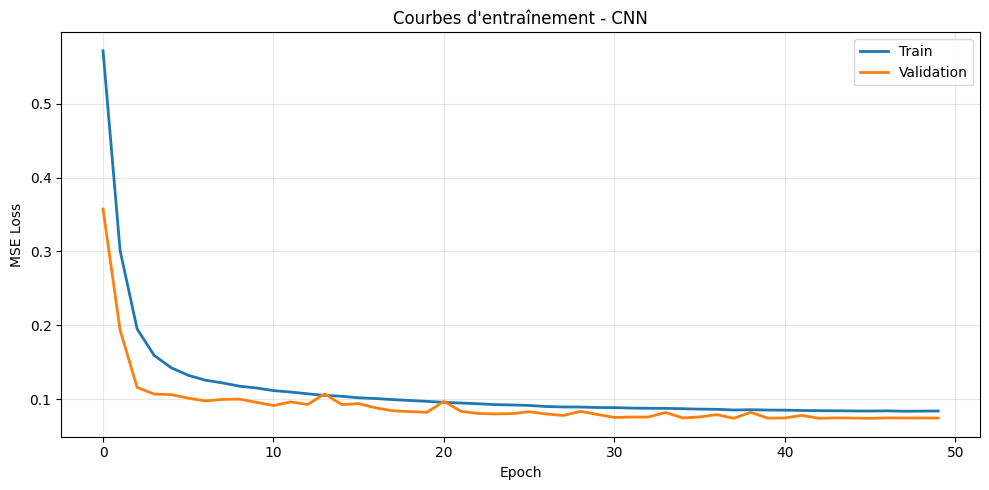

In [29]:
# Courbes d'entraînement
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train', linewidth=2)
ax.plot(val_losses, label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Courbes d\'entraînement - CNN')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Évaluation finale

In [30]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('../outputs/best_cnn.pt', map_location=DEVICE, weights_only=True))
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        pred = model(X_batch)
        all_preds.append(pred.cpu().numpy())
        all_true.append(y_batch.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
r2_x = r2_score(y_true[:, 0], y_pred[:, 0])
r2_y = r2_score(y_true[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + (y_true[:, 1] - y_pred[:, 1])**2)

print('=== CNN Temporal Bins ===')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')

=== CNN Temporal Bins ===
  MSE  : X=0.07597, Y=0.07170
  MAE  : X=0.2428, Y=0.2255
  R²   : X=0.1435, Y=0.3011
  Eucl : mean=0.3574, median=0.3585, p90=0.5371


## 8. Visualisations

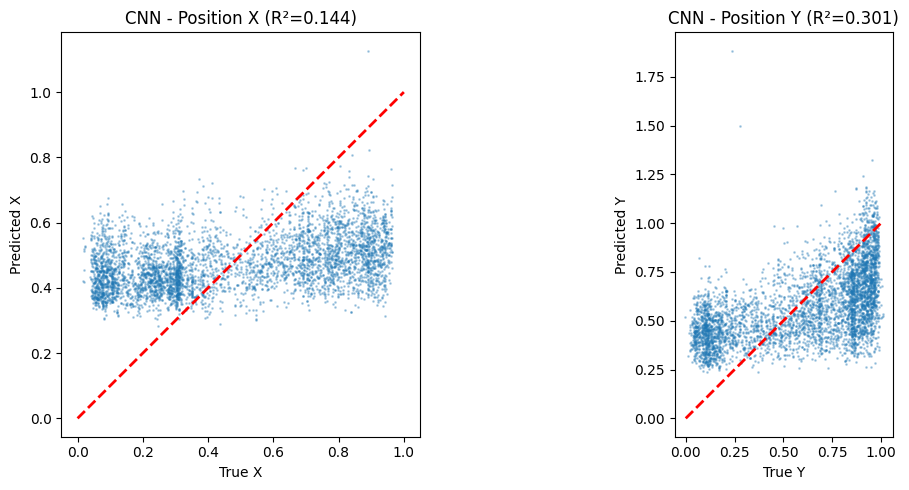

In [31]:
# --- Scatter pred vs true ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_true[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'CNN - Position X (R²={r2_x:.3f})')
axes[0].set_aspect('equal')

axes[1].scatter(y_true[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'CNN - Position Y (R²={r2_y:.3f})')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

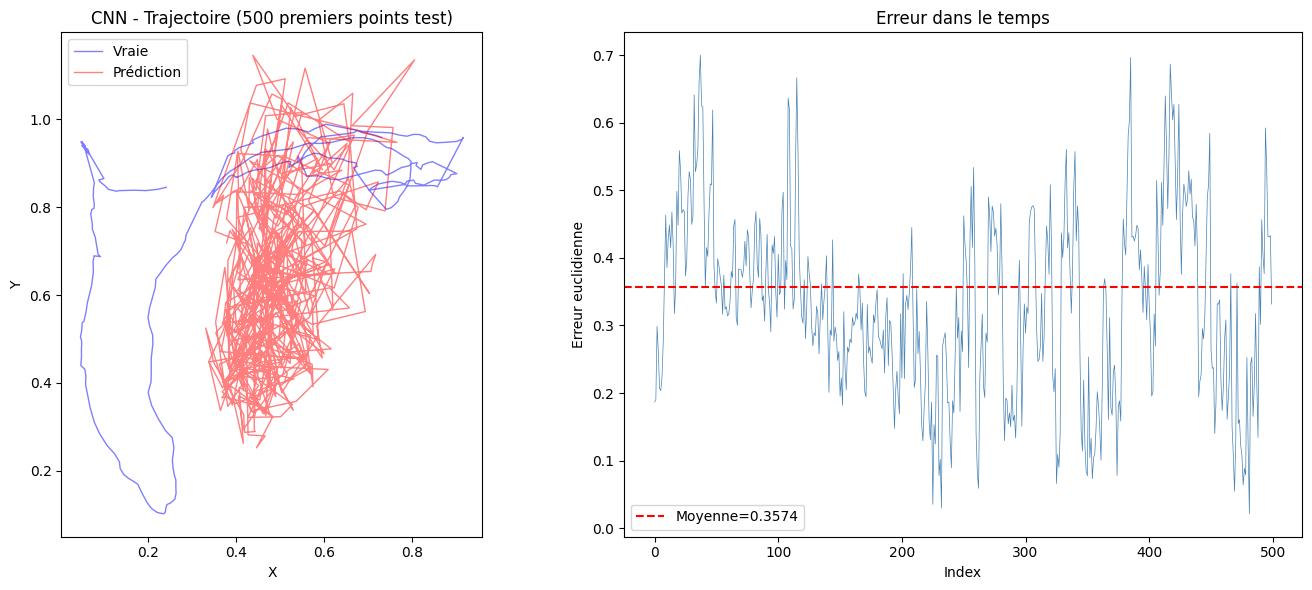

In [32]:
# --- Trajectoire prédite vs vraie ---
segment = slice(0, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(y_true[segment, 0], y_true[segment, 1], 'b-', alpha=0.5, label='Vraie', linewidth=1)
axes[0].plot(y_pred[segment, 0], y_pred[segment, 1], 'r-', alpha=0.5, label='Prédiction', linewidth=1)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('CNN - Trajectoire (500 premiers points test)')
axes[0].legend()
axes[0].set_aspect('equal')

axes[1].plot(eucl_errors[segment], color='steelblue', linewidth=0.5)
axes[1].axhline(eucl_errors.mean(), color='red', linestyle='--', label=f'Moyenne={eucl_errors.mean():.4f}')
axes[1].set_xlabel('Index'); axes[1].set_ylabel('Erreur euclidienne')
axes[1].set_title('Erreur dans le temps')
axes[1].legend()

plt.tight_layout()
plt.show()

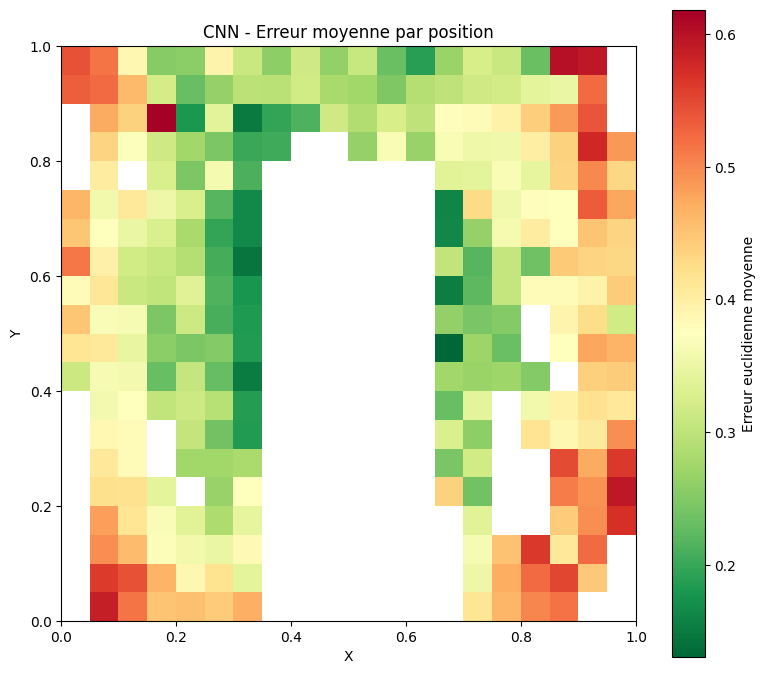

In [33]:
# --- Heatmap des erreurs spatiales ---
fig, ax = plt.subplots(figsize=(8, 7))

nbins = 20
error_map = np.full((nbins, nbins), np.nan)
count_map = np.zeros((nbins, nbins))
x_edges = np.linspace(0, 1, nbins + 1)
y_edges_map = np.linspace(0, 1, nbins + 1)

for i in range(len(y_true)):
    xi = np.clip(np.searchsorted(x_edges, y_true[i, 0]) - 1, 0, nbins - 1)
    yi = np.clip(np.searchsorted(y_edges_map, y_true[i, 1]) - 1, 0, nbins - 1)
    if np.isnan(error_map[yi, xi]):
        error_map[yi, xi] = 0
    error_map[yi, xi] += eucl_errors[i]
    count_map[yi, xi] += 1

mean_error_map = np.where(count_map > 0, error_map / count_map, np.nan)

im = ax.imshow(mean_error_map, origin='lower', aspect='equal', cmap='RdYlGn_r', extent=[0, 1, 0, 1])
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('CNN - Erreur moyenne par position')
plt.colorbar(im, ax=ax, label='Erreur euclidienne moyenne')
plt.tight_layout()
plt.show()

## 9. Sauvegarde des prédictions

In [34]:
np.save('../outputs/preds_cnn.npy', y_pred)
np.save('../outputs/y_test_cnn.npy', y_true)
print('Prédictions CNN sauvegardées.')

Prédictions CNN sauvegardées.


## 10. Post-processing : Filtre de Kalman

On applique un filtre de Kalman pour lisser les prédictions du CNN. Le CNN a des performances inférieures au Transformer (R²X=0.14, R²Y=0.30) — le Kalman devrait néanmoins réduire le bruit haute fréquence des prédictions et améliorer la cohérence temporelle de la trajectoire.

In [35]:
# --- Filtre de Kalman ---
def kalman_smooth(observations, process_noise=0.001, measurement_noise=0.01):
    """Filtre de Kalman 2D (x, y) avec modèle de position constante."""
    N = len(observations)
    smoothed = np.zeros_like(observations)
    x_est = observations[0].copy()
    P = np.eye(2) * measurement_noise
    Q = np.eye(2) * process_noise
    R = np.eye(2) * measurement_noise
    for t in range(N):
        x_pred = x_est
        P_pred = P + Q
        z = observations[t]
        y_innov = z - x_pred
        S = P_pred + R
        K = P_pred @ np.linalg.inv(S)
        x_est = x_pred + K @ y_innov
        P = (np.eye(2) - K) @ P_pred
        smoothed[t] = x_est
    return smoothed

# Configurations Kalman
kalman_configs = {
    'Kalman léger':  {'process_noise': 0.005, 'measurement_noise': 0.005},
    'Kalman moyen':  {'process_noise': 0.001, 'measurement_noise': 0.02},
    'Kalman fort':   {'process_noise': 0.0005, 'measurement_noise': 0.05},
}

kalman_results = {}
print('=== CNN brut ===')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print()

for name, params_k in kalman_configs.items():
    y_smooth = kalman_smooth(y_pred, **params_k)
    r2_sx = r2_score(y_true[:, 0], y_smooth[:, 0])
    r2_sy = r2_score(y_true[:, 1], y_smooth[:, 1])
    eucl_s = np.sqrt((y_true[:, 0] - y_smooth[:, 0])**2 + (y_true[:, 1] - y_smooth[:, 1])**2)
    kalman_results[name] = {'y_smooth': y_smooth, 'r2_x': r2_sx, 'r2_y': r2_sy, 'eucl': eucl_s}
    print(f'=== {name} (Q={params_k["process_noise"]}, R={params_k["measurement_noise"]}) ===')
    print(f'  R²   : X={r2_sx:.4f}, Y={r2_sy:.4f}')
    print(f'  Eucl : mean={eucl_s.mean():.4f}, median={np.median(eucl_s):.4f}, p90={np.percentile(eucl_s, 90):.4f}')
    print()

# Sauvegarder la meilleure version Kalman
best_kalman = min(kalman_results.items(), key=lambda x: x[1]['eucl'].mean())
print(f'Meilleur Kalman : {best_kalman[0]} (eucl mean={best_kalman[1]["eucl"].mean():.4f})')
np.save('../outputs/preds_cnn_kalman.npy', best_kalman[1]['y_smooth'])

=== CNN brut ===
  R²   : X=0.1435, Y=0.3011
  Eucl : mean=0.3574, median=0.3585, p90=0.5371

=== Kalman léger (Q=0.005, R=0.005) ===
  R²   : X=0.1613, Y=0.3427
  Eucl : mean=0.3520, median=0.3545, p90=0.5231

=== Kalman moyen (Q=0.001, R=0.02) ===
  R²   : X=0.1819, Y=0.3942
  Eucl : mean=0.3469, median=0.3499, p90=0.5029

=== Kalman fort (Q=0.0005, R=0.05) ===
  R²   : X=0.1837, Y=0.3976
  Eucl : mean=0.3495, median=0.3521, p90=0.4949

Meilleur Kalman : Kalman moyen (eucl mean=0.3469)


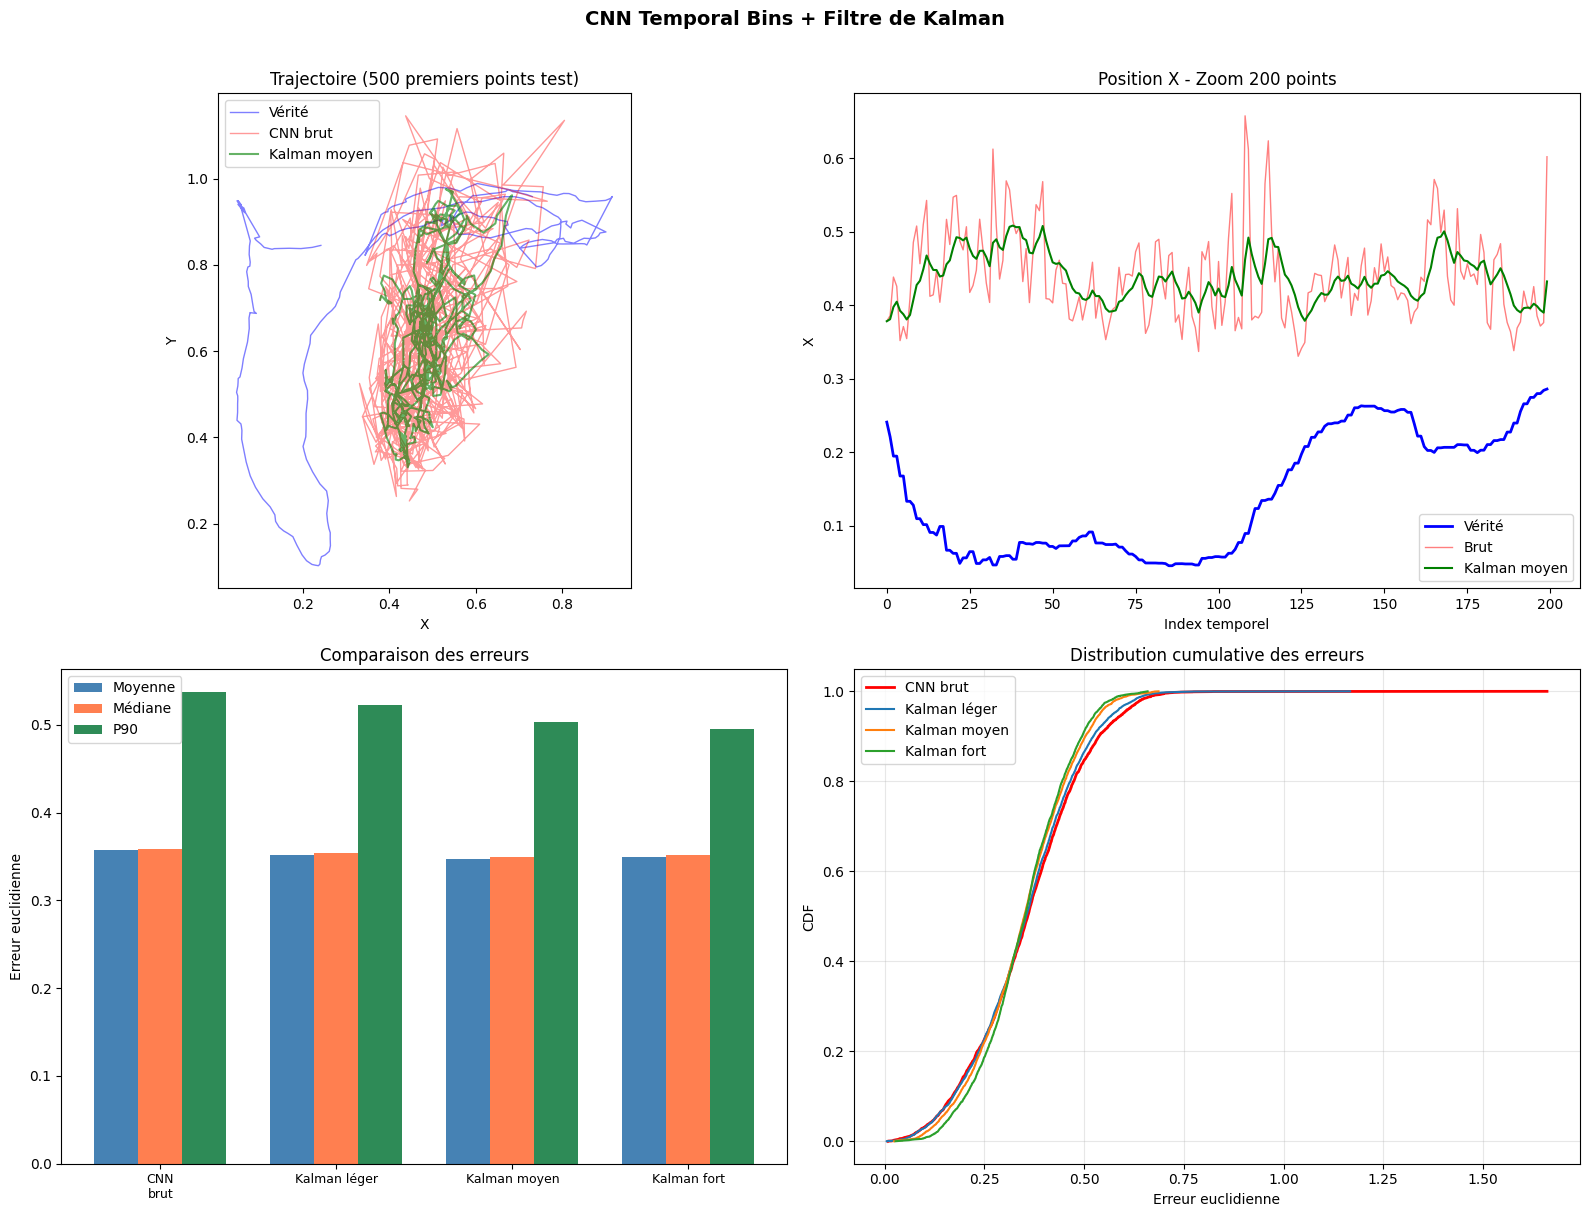

In [36]:
# --- Visualisation Kalman ---
best_name = best_kalman[0]
y_kalman = best_kalman[1]['y_smooth']
eucl_kalman = best_kalman[1]['eucl']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
seg = slice(0, 500)

# 1. Trajectoire comparée
ax = axes[0, 0]
ax.plot(y_true[seg, 0], y_true[seg, 1], 'b-', alpha=0.5, label='Vérité', linewidth=1)
ax.plot(y_pred[seg, 0], y_pred[seg, 1], 'r-', alpha=0.4, label='CNN brut', linewidth=1)
ax.plot(y_kalman[seg, 0], y_kalman[seg, 1], 'g-', alpha=0.6, label=best_name, linewidth=1.5)
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Trajectoire (500 premiers points test)')
ax.legend(); ax.set_aspect('equal')

# 2. Position X dans le temps
ax = axes[0, 1]
t_idx = np.arange(200)
ax.plot(t_idx, y_true[t_idx, 0], 'b-', label='Vérité', linewidth=2)
ax.plot(t_idx, y_pred[t_idx, 0], 'r-', alpha=0.5, label='Brut', linewidth=1)
ax.plot(t_idx, y_kalman[t_idx, 0], 'g-', label=best_name, linewidth=1.5)
ax.set_xlabel('Index temporel'); ax.set_ylabel('X')
ax.set_title('Position X - Zoom 200 points')
ax.legend()

# 3. Comparaison des erreurs par configuration
ax = axes[1, 0]
names = ['CNN\nbrut'] + list(kalman_results.keys())
means = [eucl_errors.mean()] + [v['eucl'].mean() for v in kalman_results.values()]
medians = [np.median(eucl_errors)] + [np.median(v['eucl']) for v in kalman_results.values()]
p90s = [np.percentile(eucl_errors, 90)] + [np.percentile(v['eucl'], 90) for v in kalman_results.values()]

x_pos = np.arange(len(names))
w = 0.25
ax.bar(x_pos - w, means, w, label='Moyenne', color='steelblue')
ax.bar(x_pos, medians, w, label='Médiane', color='coral')
ax.bar(x_pos + w, p90s, w, label='P90', color='seagreen')
ax.set_xticks(x_pos); ax.set_xticklabels(names, fontsize=9)
ax.set_ylabel('Erreur euclidienne')
ax.set_title('Comparaison des erreurs')
ax.legend()

# 4. CDF des erreurs
ax = axes[1, 1]
sorted_brut = np.sort(eucl_errors)
ax.plot(sorted_brut, np.linspace(0, 1, len(sorted_brut)), 'r-', label='CNN brut', linewidth=2)
for name, res in kalman_results.items():
    sorted_k = np.sort(res['eucl'])
    ax.plot(sorted_k, np.linspace(0, 1, len(sorted_k)), label=name, linewidth=1.5)
ax.set_xlabel('Erreur euclidienne'); ax.set_ylabel('CDF')
ax.set_title('Distribution cumulative des erreurs')
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle('CNN Temporal Bins + Filtre de Kalman', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 11. Interprétation

### Ce que le CNN apporte

Le CNN travaille sur une représentation "image" de l'activité neuronale :
- L'axe vertical = les 20 canaux (organisation spatiale des électrodes)
- L'axe horizontal = le temps découpé en bins de 5ms
- 2 canaux d'information : comptage et amplitude

Les filtres convolutifs peuvent capturer des patterns comme :
- Activation simultanée de canaux voisins (propagation spatiale)
- Séquences temporelles d'activation entre bins consécutifs
- Combinaisons spatio-temporelles caractéristiques d'une position

### Effet du filtre de Kalman

Le CNN a les performances brutes les plus faibles des 3 modèles. Le Kalman est donc particulièrement utile ici :
- Il compense les prédictions bruitées en exploitant la continuité temporelle
- On s'attend à un gain relatif important, surtout sur le p90 (pires cas)
- Le Kalman "fort" (R élevé) devrait être préférable, car il faut davantage "corriger" les prédictions du CNN

### Limites
- On perd le waveform individuel (seule l'amplitude max est conservée)
- Le choix du bin (5ms) est arbitraire — un bin plus fin conserve plus d'info mais augmente la sparsité
- Les canaux de différents shanks sont empilés verticalement, mais il n'y a pas de relation spatiale réelle entre le dernier canal du shank 0 et le premier du shank 1
- Le Kalman introduit un retard temporel — avec un modèle plus faible, le lag peut être plus gênant

### Améliorations possibles
- Tester différentes tailles de bin (2ms, 10ms)
- Ajouter des canaux supplémentaires (énergie, forme du spike)
- Séparer les shanks en 4 branches indépendantes avant fusion (multi-stream CNN)
- Data augmentation plus agressive
- Kalman avec modèle de vitesse constante pour mieux suivre les déplacements